# Práctica 1 - Self-Organising Maps - COLORES
## Preparación de entorno
#### Importar librerías de código

In [1]:
# from __future__ import division

import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
from matplotlib import patches as patches
pd.options.display.max_columns = None

%matplotlib inline

#### Dataset que se va a utilizar para el entrenamiento

In [2]:
# Código para obtener el Dataset que se va a usar en el entrenamiento
# Importamos el csv, quitamos los nan y los duplicados
#datos = np.random.randint(valor_min, valor_max, (valores_color, num_colores))
paises = pd.read_csv('Countries2010.csv', encoding='latin-1')
paises = paises.set_index(paises['CountryName'])
paises = paises.drop('CountryName', 1)
paises = paises.dropna()
paises = paises.drop_duplicates()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_12752\2137929968.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  paises = paises.drop('CountryName', 1)


In [3]:
# Normalizamos por columnas para que la matriz entrene correctamente y creamos otra matriz
# para usarla en el mapamundi

paisesEntrenamiento = paises.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)), axis = 0)
#paisesEntrenamiento = paisesEntrenamiento2.to_numpy()
paisesMapa = paisesEntrenamiento[['GDP per capita (current US$)']]
paisesMapa = paisesMapa.reset_index()
fila = paisesEntrenamiento.iloc[1]
arrayFila = fila.values
a = paisesEntrenamiento.index
paisesResultado = pd.DataFrame({'Nombre': a})
paisesResultado['BMU'] = None

## SOM Setup
#### Variables definidas por el alumno

In [4]:
# Inicializa tamaño del mapa de Kohonen, número de iteraciones y learning rate
# Inicializa normalizar_datos dependiendo de si tienes que normalizar los datos o no
lado_mapa = 15
periodo = 30000
learning_rate = 0.01 
normalizar_datos = True

#### A partir de este punto solo hay cálculos. No se introducen más valores "a mano"

In [5]:
# Establece el numero de entradas del mapa y el número de datos que se van a usar para entrenar. 
# Utiliza una función que obtenga automáticamente los valores a partir del Dataset.
num_entradas = paisesEntrenamiento.shape[1]
num_datos = paisesEntrenamiento.shape[0]

# Calcula el vecindario inicial. Debe ser la mitad del lado del mapa de Kohonen
vecindario = lado_mapa/2

# Normaliza los datos si fuese necesario dividiendo cada dato por el máximo en la matriz
if normalizar_datos:
    False
    
# Crea una matriz de pesos con valores random entre 0 y 1. Usa la función random.random de la librería NumPy
matriz_pesos = np.random.random(size=(lado_mapa, lado_mapa, 17))

# Crea el mapa de clasificación
matrizClas = np.zeros((lado_mapa, lado_mapa, 17))

# Creamos la matriz de activaciones
matrizAct = np.zeros((lado_mapa, lado_mapa))

# Creamos la matriz de distancias
matrizDist = np.zeros((lado_mapa, lado_mapa))

# Creamos la matriz de etiquetas
matrizEtiq = np.zeros((lado_mapa, lado_mapa), dtype = object)

# Creamos la matriz de GDP
matrizGDP = np.zeros((lado_mapa, lado_mapa))

# Creamos la matriz de mortalidad neonatal
matrizMort = np.zeros((lado_mapa, lado_mapa))

# Creamos la matriz de clasificacion, de distancias y de activaciones de la clasificación
matrizClas2 = np.empty((lado_mapa, lado_mapa), dtype = object)
longitud_cadena = 1000000
for fila in range(matrizClas2.shape[0]):
    for columna in range(matrizClas2.shape[1]):
        matrizClas2[fila, columna] = '' * longitud_cadena
matrizAct2 = np.zeros((lado_mapa, lado_mapa))
matrizDist2 = np.zeros((lado_mapa, lado_mapa))

#### Funciones para entrenar/clasificar

In [6]:
# Función para encontrar la BMU
"""
   Encuentra la BMU para un patrón de entrada.
   Entradas: (patrón_de_entrada, matriz_de_pesos, número_de_entradas)
   Salidas:  (bmu, bmu_idx) tupla donde
               bmu: vector de pesos de la neurona ganadora
               bum_idx: coordenadas de la neurona ganadora
"""

def dist(x, y):
    return sum(abs(x-y))

def distancia_euclidiana(x, y):
    return np.sqrt(np.sum((x - y)**2))

def calcular_bmu(entrada, pesos, num_entradas, num_rows, num_cols):
    winner = [0,0]
    shortest_distance = np.sqrt(paisesEntrenamiento.shape[1])
    for row in range(num_rows):
        for col in range(num_cols):
            distance = distancia_euclidiana(pesos[row][col], entrada)
            if distance < shortest_distance:
                shortest_distance = distance
                winner = [row, col]
    return winner, shortest_distance

In [7]:
# Función para calcular el descenso del coeficiente de aprendizaje (eta)
"""
   Calcula el Learning Rate (eta) que corresponde a la i-ésima presentación.
   Entradas: (learning_rate_inicial, iteracion, período)
   Salidas:  learning_rate para la iteración i

"""
def variacion_learning_rate(lr_inicial, i, n_iteraciones):
    lr_actual = lr_inicial*(1-(i/n_iteraciones))
    return lr_actual

In [8]:
# Función para calcular el descenso del vecindario (v)
"""
   Calcula el vecindario  (v) que corresponde a la i-ésima presentación.
   Entradas: (vecindario_inicial, iteracion, período)
   Salidas:  lvecindario para la iteración i

"""
def variacion_vecindario(vecindario_inicial, i, n_iteraciones):
    vecin_act = 1 + vecindario_inicial*(1 - (i/n_iteraciones))
    return vecin_act

In [9]:
# Función para calcular el descenso del coeficiente de aprendizaje (eta) en función de la distancia a la BMU
"""
   Calcula la amortiguación de eta en función de la distancia en el mapa entre una neurona y la BMU.
   Entradas: (distancia_BMU, vecindario_actual)
   Salidas:  amortiguación para la iteración

"""
def decay(distancia_BMU, vecindario_actual):
    return np.exp(-distancia_BMU**2 / (2*vecindario_actual**2))

#### Funciones para dibujar la salida de la red

In [10]:
# Función para pintar una matriz de valores como colores RGB
def pintar_mapa(matriz_valores):
    fig = plt.figure()
    
    # Establece ejes
    ax = fig.add_subplot(111, aspect='equal')
    ax.set_xlim((0, matriz_pesos.shape[0]+1))
    ax.set_ylim((0, matriz_pesos.shape[1]+1))
    ax.set_title('Self-Organising Map después de %d iteraciones' % periodo)

    # Dibuja los rectángulos de color RGB
    for x in range(1, matriz_valores.shape[0] + 1):
        for y in range(1, matriz_valores.shape[1] + 1):
            ax.add_patch(patches.Rectangle((x-0.5, y-0.5), 1, 1,
                         facecolor=matriz_valores[x-1,y-1,:],
                         edgecolor='none'))
    plt.show()

## SOM Entrenamiento

In [11]:
# Entrena la red con el dataset de entrenamiento
# Creamos un bucle con las vueltas del periodo, vamos variando el learning rate y el vecindario.
# Añadimos la información a las matriz de las BMU, las distancias y las clases creadas, así como la última BMU
# que ha reconocido a un país

for step in range(periodo):
    if (step % 1000 == 0):
        print("Vuelta ", step, " completada")
    lr = variacion_learning_rate(learning_rate, step, periodo)
    vecin = variacion_vecindario(vecindario, step, periodo)
    numero = np.random.randint(0, 170)
    fila = paisesEntrenamiento.iloc[numero]
    aleatorio = fila.values
    aleatorio = np.array(aleatorio)
    winner, dista = calcular_bmu(aleatorio, matriz_pesos, 3, lado_mapa, lado_mapa)
    matrizClas[winner[0], winner[1]] = aleatorio
    matrizAct[winner[0], winner[1]] += 1
    matrizDist[winner[0], winner[1]] += dista
    matrizEtiq[winner[0], winner[1]] = fila.name
    paisesResultado.loc[paisesResultado['Nombre'] == fila.name, 'BMU'] = paisesResultado['BMU'].apply(lambda x: winner)
    
    for row in range(lado_mapa):
        for col in range(lado_mapa):
            sitio = np.array([row, col])
            distancia = distancia_euclidiana(matriz_pesos[winner[0], winner[1]], matriz_pesos[row, col])
            amort = decay(distancia, vecin)
            if dist(sitio, winner) <= vecin:
                matriz_pesos[row][col] += lr*amort*(aleatorio-matriz_pesos[row][col])
print("Entrenamiento completado")

Vuelta  0  completada
Vuelta  1000  completada
Vuelta  2000  completada
Vuelta  3000  completada
Vuelta  4000  completada
Vuelta  5000  completada
Vuelta  6000  completada
Vuelta  7000  completada
Vuelta  8000  completada
Vuelta  9000  completada
Vuelta  10000  completada
Vuelta  11000  completada
Vuelta  12000  completada
Vuelta  13000  completada
Vuelta  14000  completada
Vuelta  15000  completada
Vuelta  16000  completada
Vuelta  17000  completada
Vuelta  18000  completada
Vuelta  19000  completada
Vuelta  20000  completada
Vuelta  21000  completada
Vuelta  22000  completada
Vuelta  23000  completada
Vuelta  24000  completada
Vuelta  25000  completada
Vuelta  26000  completada
Vuelta  27000  completada
Vuelta  28000  completada
Vuelta  29000  completada
Entrenamiento completado


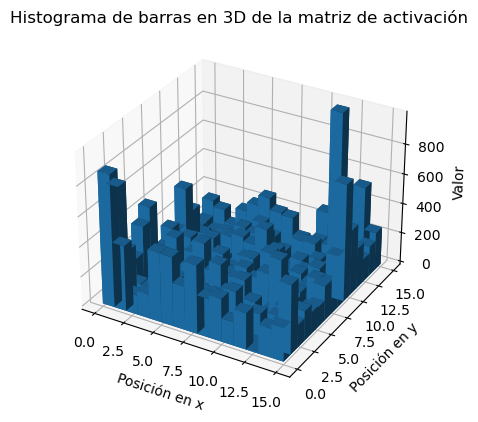

In [15]:
x, y = np.meshgrid(np.arange(matrizAct.shape[0]), np.arange(matrizAct.shape[1]))
z = matrizAct.flatten()

# Crear un gráfico 3D de barras
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.bar3d(x.ravel(), y.ravel(), np.zeros_like(z), 1, 1, z)

# Establecer etiquetas y título
ax.set_xlabel('Posición en x')
ax.set_ylabel('Posición en y')
ax.set_zlabel('Valor')
ax.set_title('Histograma de barras en 3D de la matriz de activación')

# Mostrar el gráfico
plt.show()

## SOM Clasificación

In [138]:
# Para obtener el error, clasificamos la matriz con el set de datos de los países, pero esta vez
# en orden y solo una vez cada uno

paisesClas = paisesEntrenamiento
distanciaTotal = 0

for i in range(171):
    fila = paisesEntrenamiento.iloc[i]
    aleatorio = fila.values
    aleatorio = np.array(aleatorio)
    winner, dista = calcular_bmu(aleatorio, matriz_pesos, 3, lado_mapa, lado_mapa)
    matrizClas2[winner[0], winner[1]] += fila.name + " "
    matrizAct2[winner[0], winner[1]] += 1
    matrizDist2[winner[0], winner[1]] += dista
    distanciaTotal += dista
print("Ha terminado de clasificar")

# Quitar el comentario de las siguientes líneas si queremos ver los mapas
#print(matrizClas2)
#print(matrizAct2)
#print(matrizDist2)

Ha terminado de clasificar


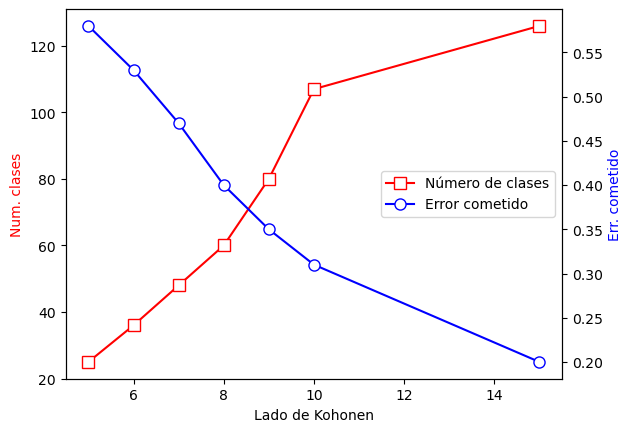

In [139]:
# A base de prueba y error, añadimos los errores y el número de clases por cada lado del mapa de Kohonen
# para crear la gráfica correspondiente

ladoKohonen = [5, 6, 7, 8, 9, 10, 15]
ladoKohonen = np.array(ladoKohonen)
numeroClases = [25, 36, 48, 60, 80, 107, 126]
numeroClases = np.array(numeroClases)
errorCometido = [0.58, 0.53, 0.47, 0.40, 0.35, 0.31, 0.2]

# Crear la figura y los ejes
fig, ax1 = plt.subplots()

# Crear el segundo eje y asociarlo con el primer eje
ax2 = ax1.twinx()

# Crear las líneas de datos y asociarlas con los ejes correspondientes
line1, = ax1.plot(ladoKohonen, numeroClases, '-s', markerfacecolor='white', markersize=8, color='red', label='Número de clases')
line2, = ax2.plot(ladoKohonen, errorCometido, '-o', markerfacecolor='white', markersize=8, color='blue', label='Error cometido')

# Configurar los ejes y las etiquetas
ax1.set_xlabel('Lado de Kohonen')
ax1.set_ylabel('Num. clases', color='red')
ax2.set_ylabel('Err. cometido', color='blue')

# Agregar leyendas
lines = [line1, line2]
ax1.legend(lines, [l.get_label() for l in lines], loc = 'right')

# Mostrar la gráfica
plt.show()

Viendo esta gráfica, podemos ver que con un lado de mapa de Kohonen el error baja a 0.2 con un periodo de 30000. Por ello, podemos concluir que son los mejores hiperparámetros a la hora de definir nuestro mapa.

In [140]:
# Aquí comprobamos la BMU que ha reconocido a los 3 países del enunciado con el fin de comprobar 
# los grupos a los que pertenecen

paisesResultado
a = paisesResultado.loc[paisesResultado['Nombre'] == 'Venezuela, RB']
b = paisesResultado.loc[paisesResultado['Nombre'] == 'Ethiopia']
c = paisesResultado.loc[paisesResultado['Nombre'] == 'Norway']

ven = a['BMU'].values
venez = ven[0]
eth = b['BMU'].values
ethi = eth[0]
nor = c['BMU'].values
norw = nor[0]

print(a)
print(b)
print(c)
print("El vector de pesos de Venezuela es: ", matriz_pesos[venez[0], venez[1]])
print("El vector de pesos de Etiopía es: ", matriz_pesos[ethi[0], ethi[1]])
print("El vector de pesos de Noruega es: ", matriz_pesos[norw[0], norw[1]])

            Nombre      BMU
165  Venezuela, RB  [1, 14]
      Nombre     BMU
49  Ethiopia  [5, 0]
     Nombre       BMU
114  Norway  [12, 14]
El vector de pesos de Venezuela es:  [0.22835188 0.10488598 0.01438236 0.03295185 0.85779789 0.2192693
 0.08751448 0.14549813 0.47433782 0.17320914 0.42603687 0.7650598
 0.23494019 0.65226682 0.36657112 0.18466002 0.19780567]
El vector de pesos de Etiopía es:  [0.39066501 0.00649252 0.00138344 0.20663078 0.31797819 0.50449757
 0.32266121 0.43709133 0.79539688 0.09861399 0.2931211  0.164264
 0.835736   0.16678968 0.06278756 0.01379441 0.12509708]
El vector de pesos de Noruega es:  [0.03836401 0.53934056 0.09523647 0.00693383 0.99824572 0.0265441
 0.00858279 0.01496523 0.11090936 0.6613181  0.48720043 0.83917545
 0.16082455 0.59172728 0.8965743  0.39882407 0.06150608]


In [141]:
# Aquí imprimimos las BMU que se han activado más de 500 veces con el fin de reconocer los distintos
# clusters que ha hecho la red neuronal

posiciones = np.where(matrizAct >= 500)
print("Valores donde se crean los grupos: ", matrizAct[posiciones])
coordenadas = list(zip(posiciones[0], posiciones[1]))
coordenadas
print("Las posiciones en la matriz de esos valores son: ", coordenadas)

Valores donde se crean los grupos:  [939. 579. 954. 661. 959.]
Las posiciones en la matriz de esos valores son:  [(0, 0), (0, 1), (13, 14), (14, 9), (14, 14)]


In [142]:
# Creamos un mapa con las distancias de las BMU para crear un mapa en escala de grises que nos indique
# donde se han creado los grupos por medio de la escala de grises

map = np.zeros((lado_mapa, lado_mapa))
for i in range(lado_mapa):
    for j in range(lado_mapa):
        map[i, j] = np.linalg.norm(matriz_pesos[i, j] - matriz_pesos)

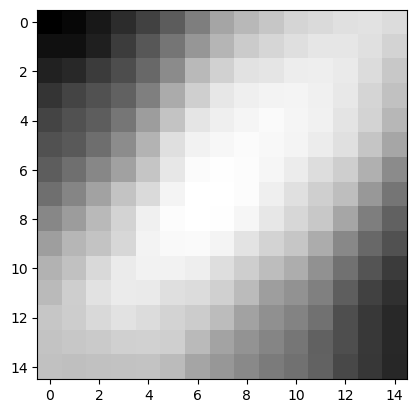

In [143]:
plt.imshow(map, cmap='gray_r')
plt.show()

Podemos comprobar la posición de los clusters ya que donde hay más agrupación de países, el mapa está en negro; y donde no hay países, el mapa tiene un tono blanco.

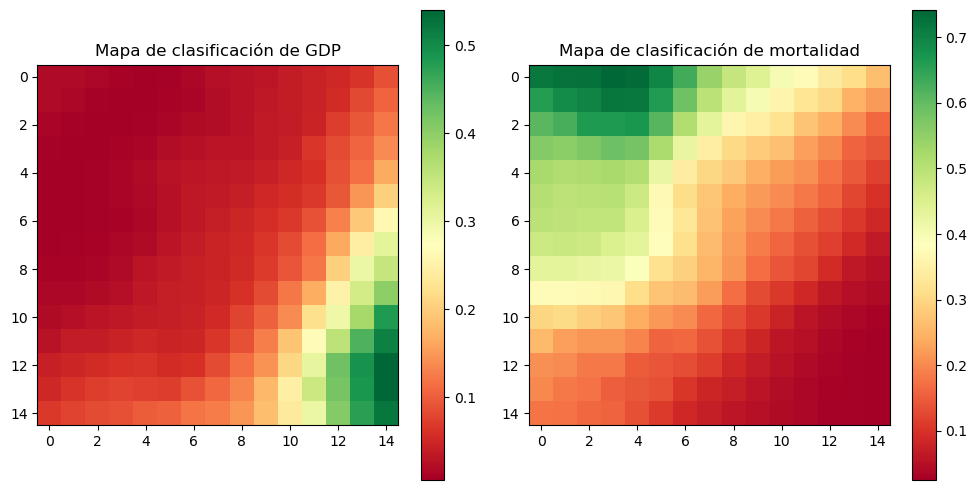

In [144]:
# Creamos ambos mapas de clasificación por GDP y mortalidad a partir de la matriz de pesos entrenada, 
# utilizando solo la característica de GDP y mortalidad

for i in range(lado_mapa):
    for j in range(lado_mapa):
        matrizGDP[i, j] = matriz_pesos[i, j, 1]
        matrizMort[i, j] = matriz_pesos[i, j, 5]
        
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
x = axs[0].imshow(matrizGDP, cmap='RdYlGn')
y = axs[1].imshow(matrizMort, cmap='RdYlGn')
axs[0].set_title('Mapa de clasificación de GDP')
axs[1].set_title('Mapa de clasificación de mortalidad')
fig.colorbar(x, ax=axs[0])
fig.colorbar(y, ax=axs[1])
plt.tight_layout()
plt.show()

Como podemos ver, hay una zona verde lo que indica un aumento en lo que tratamos en el mapa. Es decir, la zona verde del mapa de GDP nos indica la zona donde los países con mayor GDP se agrupan. Lo más interesante es que la zona más roja del mapa de GDP es la zona más verde del mapa de mortalidad, lo cual es lógico, puesto que los países con menos GDP serán aquellos en los que las condiciones de vida no son óptimas y por ello tienen mayor mortalidad.

<u>PCA</u>

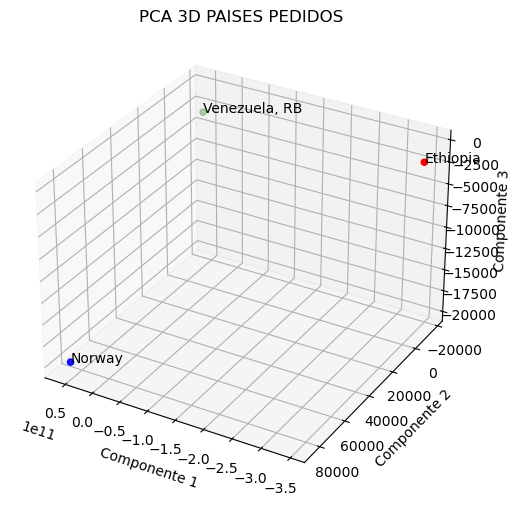

In [145]:
#ESTANDARIZAMOS DATOS:
#leemos el fichero countries.csv y lo preprocesamos(estandarizacion de los datos)

# Cargar datos desde un archivo CSV
from sklearn.preprocessing import StandardScaler
data = pd.read_csv("Countries2010.csv")
            
# Excluir columnas que contienen valores no numéricos
data_numeric = data.select_dtypes(include=[float, int])
# Crear un objeto StandardScaler y ajustarlo a los datos
scaler = StandardScaler()
scaler.fit(data_numeric)
# Transformar los datos utilizando el objeto StandardScaler
data_transformed = scaler.transform(data_numeric)

# Crear un DataFrame de Pandas con los datos transformados
data_transformed = pd.DataFrame(data_transformed, columns=data_numeric.columns)
#data_transformed

#Parte 2
# Calcular la matriz de covarianza
cov_mat = np.cov(data_transformed.T)

# Obtener los autovalores y autovectores
autovalores, autovectores = np.linalg.eig(cov_mat)
# Calcular el porcentaje de varianza explicado por cada componente
porcentaje_varianza = autovalores / np.sum(autovalores)

# Calcular el porcentaje acumulado de varianza explicado
porcentaje_acumulado = np.cumsum(porcentaje_varianza)

# Crear un DataFrame con los porcentajes de varianza y acumulado
df_porcentajes = pd.DataFrame({
    'Porcentaje de Varianza': porcentaje_varianza,
    'Porcentaje Acumulado': porcentaje_acumulado
})
df_porcentajes

#3Parte 3
#Mostramos Analisis de Autovectores
componente1 = autovectores[:, 0]
componente2 = autovectores[:, 1]
componente3 =autovectores[:,2]
df_Componentes = pd.DataFrame({
    'Componente1': componente1,
    'Componente2': componente2,
    'Componente3': componente3
}, index=paises.columns)
df_Componentes

import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
import pandas as pd
from sklearn.decomposition import PCA

data = pd.read_csv("Countries2010.csv")
labels = data['CountryName']#Para poder poner etiquetas

pca = PCA(n_components=3)  # especificar 3 componentes principales
paises = data.drop(['CountryName'], axis=1)
pca.fit(paises)
componentes_principales = pca.components_
varianza_explicada = pca.explained_variance_ratio_
data_transformedPCA = pca.transform(paises)

fig = plt.figure()
fig.set_size_inches(8, 6)
ax = fig.add_subplot(111, projection='3d')  # crear un subplot en 3 dimensiones
ax.view_init(elev=30, azim=120)

# filtrar los puntos que coinciden con los labels deseados
labels_deseados = ['Norway', 'Ethiopia', 'Venezuela, RB']
#labels_deseados = ['United States', 'Ethiopia', 'Venezuela, RB']
indices_deseados = [i for i, label in enumerate(labels) if label in labels_deseados]
data_deseados = data_transformedPCA[indices_deseados]
labels_deseados = [labels[i] for i in indices_deseados]

ax.scatter(data_deseados[:, 0], data_deseados[:, 1], data_deseados[:, 2], c=['red', 'blue', 'green'])
ax.set_xlabel('Componente 1')
ax.set_ylabel('Componente 2')
ax.set_zlabel('Componente 3')
for i, label in enumerate(labels_deseados):
    ax.text(data_deseados[i, 0], data_deseados[i, 1], data_deseados[i, 2], label)
    
plt.title('PCA 3D PAISES PEDIDOS')
plt.show()

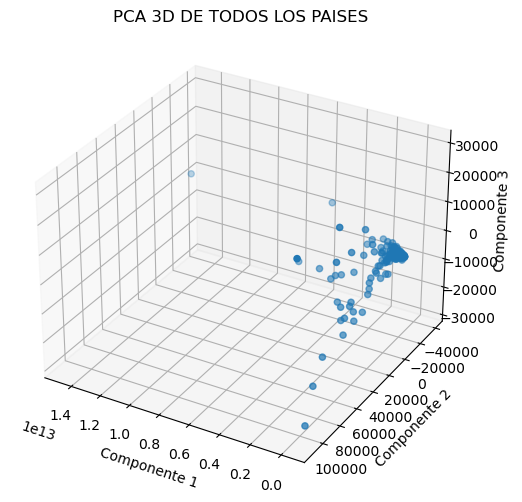

In [146]:
#Represento todos en 3D
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
import pandas as pd
from sklearn.decomposition import PCA

data = pd.read_csv("Countries2010.csv")
labels = data['CountryName']  # Para poder poner etiquetas

pca = PCA(n_components=3)  # especificar 3 componentes principales
paises = data.drop(['CountryName'], axis=1)
pca.fit(paises)
componentes_principales = pca.components_
varianza_explicada = pca.explained_variance_ratio_
data_transformedPCA = pca.transform(paises)

fig = plt.figure()
fig.set_size_inches(8, 6)
ax = fig.add_subplot(111, projection='3d')  # crear un subplot en 3 dimensiones
ax.view_init(elev=30, azim=120)

ax.scatter(data_transformedPCA[:, 0], data_transformedPCA[:, 1], data_transformedPCA[:, 2])
ax.set_xlabel('Componente 1')
ax.set_ylabel('Componente 2')
ax.set_zlabel('Componente 3')
#for i, label in enumerate(labels):
 #   ax.text(data_transformedPCA[i, 0], data_transformedPCA[i, 1], data_transformedPCA[i, 2], label)

plt.title('PCA 3D DE TODOS LOS PAISES')
plt.show()

<u>IMPORTANTE</u>

Para la creación del mapamundi es necesaria la instalación de dos librerias. Si no están instaladas deberán instalarse. Con quitar el comentario en las tres siguientes líneas de código, al ejecutarlo se instalarán correctamente.

In [147]:
#import sys
#!{sys.executable} -m pip install geopandas
#!{sys.executable} -m pip install mapclassify

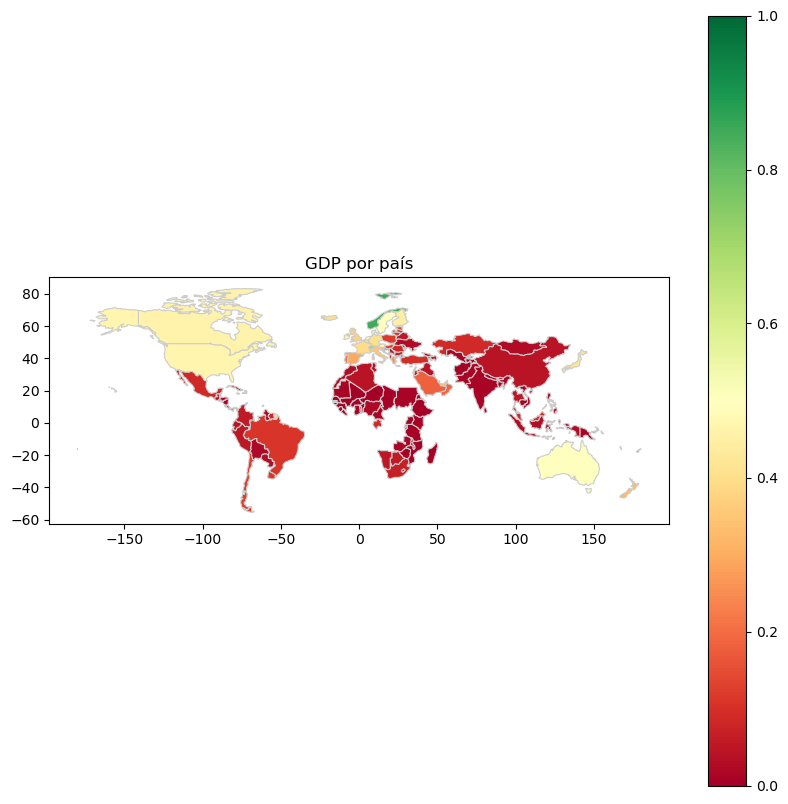

In [5]:
# A partir de la matriz de pesos y del mapa de la mortalidad, con ayuda de estas dos librerías
# podemos crear un mapamundi y pintar de colores los países por su GDP.
# Cuanto más rojo menos GDP y cuanto más verde mayor.

import geopandas as gpd
import mapclassify

paisesMapa['CountryName'] = paisesMapa['CountryName'].replace('United States', 'United States of America')
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
merged_data = world.merge(paisesMapa, left_on='name', right_on='CountryName')
fig, ax = plt.subplots(figsize=(10, 10))
merged_data.plot(column='GDP per capita (current US$)', cmap='RdYlGn', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
#merged_data.apply(lambda x: ax.annotate(text=x['name'], xy=x.geometry.centroid.coords[0], ha='center', fontsize=7), axis=1);
plt.title('GDP por país')
plt.show()